In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import SessionTools.two_photon as st2p

import sklearn
from sklearn.linear_model import LinearRegression as LinReg

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
# List EL sessions

sess_info = ({'date': '15_03_2023', 
              'name': 'EPG_GCaMP_EL_jRGECO_fly2',
              'session_list': ['baseline_open_loop-003']},
             {'date': '16_03_2023',
              'name': 'EPG_GCaMP_EL_jRGECO_fly1',
              'session_list': ['open_loop_baseline-000',
                           'open_loop_baseline-001']},
             {'date': '16_03_2023',
              'name': 'EPG_GCaMP_EL_jRGECO_fly2',
              'session_list': ['open_loop_baseline-000',
                           'open_loop_baseline-001']},
             {'date': '15_03_2023',
              'name': 'EPG_GCaMP_EL_jRGECO_fly1',
              'session_list': ['baseline_open_loop-000']},
             {'date': '17_03_2023',
              'name': 'EPG_GCaMP_EL_jRGECO_fly1',
              'session_list': ['open_loop_baseline-002',
                           'open_loop_baseline-003',
                           'closed_loop_to_dark-006',
                           'closed_loop_to_dark-007']},
             {'date': '17_03_2023',
              'name': 'EPG_GCaMP_EL_jRGECO_fly2',
              'session_list': ['open_loop_baseline-001',
                           'open_loop_baseline-003',
                           'closed_loop_to_dark-004']},
            )





In [3]:

# make session class 

class Session:
    
    def __init__(self, date, name, session_list, func_ch=(0,1), align_ch=0) -> None:
        self.date = date
        self.name = name
        self.session_list = session_list
        
        self.func_ch=func_ch
        self.align_ch=align_ch
        
        self.basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{name}/')
        
        self.timeseries = {'voltage_recording': [],
                           'F': [],
                           'notF': [],
                           'dff': [],
                           'heading': [],
                           'pva_amp': [],
                           'pva_angle': [],
                           'offset': []}
        
        
        
        for sess in session_list:
            self.get_processed_data(sess)
            
        for k,v  in self.timeseries.items():
            self.timeseries[k] = tuple(v)
            
        self.timeseries_concat = {'voltage_recording': None,
                           'F': None,
                           'notF': None,
                           'dff': None,
                           'heading': None,
                           'pva_amp': None,
                           'pva_angle': None,
                           'offset': None}
        
        concat_timeseries = lambda ts: np.concatenate([_ts for _ts in ts], axis=-1)
        for k,v in self.timeseries.items():
            if k not in ('voltage_recording'):
                self.timeseries_concat[k] = concat_timeseries(v)
            else:
                self.timeseries_concat['voltage_recording'] = pd.concat(v)
                    
    def save(self):
        fname = f"/media/mplitt/SSD_storage/2P_scratch/{self.date}/{self.name}/sess_class.pkl"
        with open(fname, 'wb') as file:
            cloudpickle.dump(self,file)
        
    @staticmethod
    def make_h5(h5name, metadata, basename_input):
        if not os.path.exists(h5name):
            tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                                           metadata['size'],metadata['layout'])
            st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)
    
    @staticmethod
    def calc_pva(dff):
        x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[np.newaxis,:,np.newaxis])
        rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=1), y_f.mean(axis=1))
        return rho, phi
    
    @staticmethod
    def calc_offset(heading, pva_angle):
        _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(pva_angle.shape),pva_angle-heading[np.newaxis,:]))
        return offset
    
    def get_processed_data(self, sess_name):

        basename_input = pathlib.Path(self.basedir.joinpath(sess_name).joinpath(sess_name))
        metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

        # raw data
        h5name = f'/media/mplitt/SSD_storage/2P_scratch/{self.date}/{self.name}/{sess_name}/data.h5'
        self.make_h5(h5name, metadata, basename_input)
        f = h5py.File(h5name)
        data = f['/data'][:]
    
        # motion corrected
        ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
        data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[self.align_ch,:,:,:], in_place=False)
    
    
        # ROI data
        napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{self.date}/{self.name}/{sess_name}/napari.pkl'
        with open(napari_outputs_file, 'rb') as file:
            np_layers = cloudpickle.load(file)
        masks = np_layers['rois']
    
        # voltage recording data
        csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{self.date}/{self.name}/{sess_name}/*.csv')
        vr_file = pathlib.Path(csv_files[0])
        df = dd.read_csv(vr_file).compute()
    
        # align voltage recording and imaging data
        frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
        df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)
    
        # extract fluorescence
        F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, max_proj=False) #+ 1E-3
        for ch in range(F.shape[0]):
            lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
            F[ch,:,:] = F[ch,:,:]-1.*lr.predict(notF[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]
    
        
        F = sp.ndimage.gaussian_filter1d(F,2,axis=-1) # smooth in time
        F = sp.ndimage.gaussian_filter1d(F,.25,axis=1, mode='wrap') # smooth in space
        
        
        dff = sp.stats.zscore(F,axis=-1)
        
    
        # put heading back in correct range
        _, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))
        pva_amp, pva_angle = self.calc_pva(dff)
        offset = self.calc_offset(heading, pva_angle)
        
        self.timeseries['voltage_recording'].append(df_aligned)
        self.timeseries['F'].append(F)
        self.timeseries['notF'].append(notF)
        self.timeseries['dff'].append(dff)
        self.timeseries['heading'].append(heading)
        self.timeseries['pva_amp'].append(pva_amp)
        self.timeseries['pva_angle'].append(pva_angle)
        self.timeseries['offset'].append(offset)
        
        
        

In [4]:
print(sess_info)

({'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['baseline_open_loop-003']}, {'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}, {'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}, {'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['baseline_open_loop-000']}, {'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-002', 'open_loop_baseline-003', 'closed_loop_to_dark-006', 'closed_loop_to_dark-007']}, {'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-001', 'open_loop_baseline-003', 'closed_loop_to_dark-004']})


In [15]:
for s in sess_info[-1:]:
    sess = Session(**s)
    sess.save()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [5]:
len(sess.timeseries['dff'])

NameError: name 'sess' is not defined

In [5]:
for s in sess_info:
    fname = f"/media/mplitt/SSD_storage/2P_scratch/{s['date']}/{s['name']}/sess_class.pkl"
    with open(fname, 'rb') as file:
        sess = cloudpickle.load(file)

In [6]:
sess.timeseries.keys()

dict_keys(['voltage_recording', 'F', 'notF', 'dff', 'heading', 'pva_amp', 'pva_angle', 'offset'])

In [7]:
def load_session(sess_deets):
    fname = f"/media/mplitt/SSD_storage/2P_scratch/{sess_deets['date']}/{sess_deets['name']}/sess_class.pkl"
    with open(fname, 'rb') as file:
        sess = cloudpickle.load(file)
    return sess

{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['baseline_open_loop-003']}
0
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
0
1
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
0
1
{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['baseline_open_loop-000']}
0
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-002', 'open_loop_baseline-003', 'closed_loop_to_dark-006', 'closed_loop_to_dark-007']}
0
1
2
3
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-001', 'open_loop_baseline-003', 'closed_loop_to_dark-004']}
0
1
2


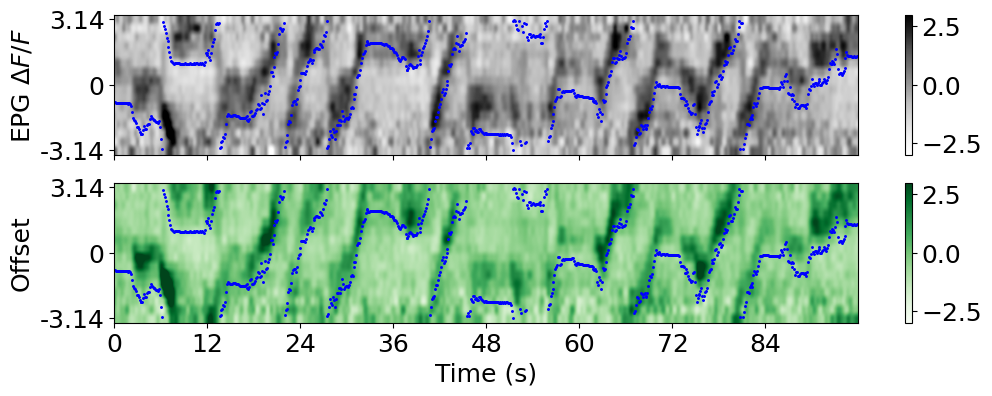

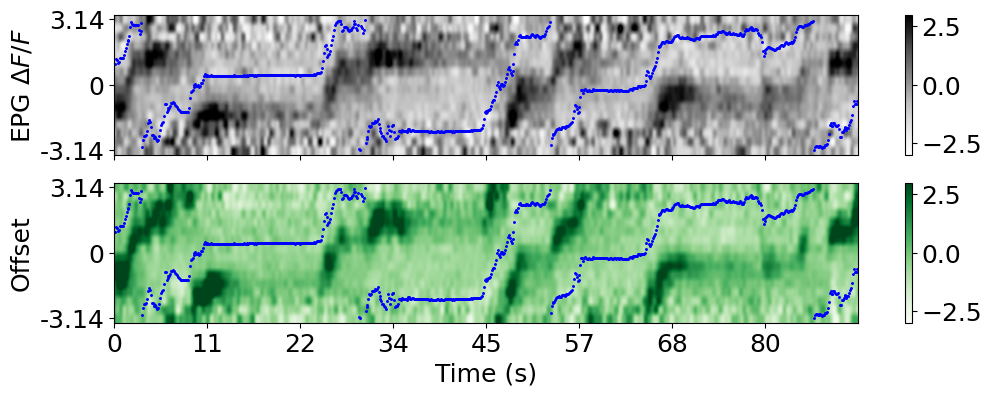

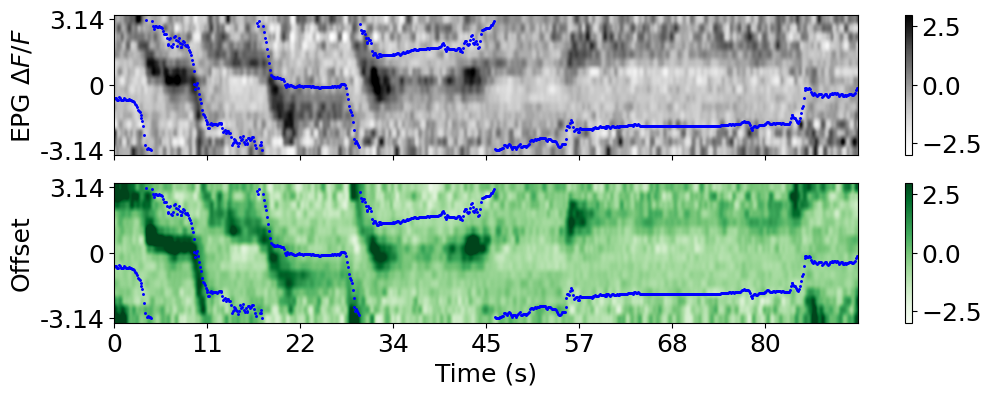

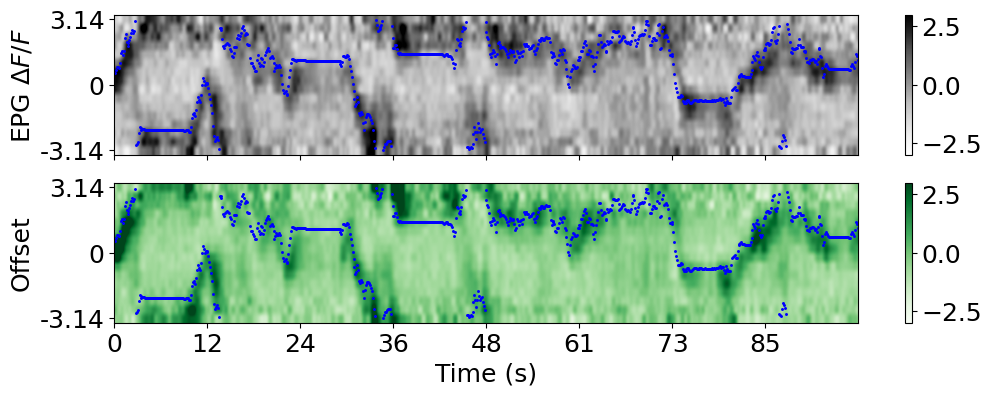

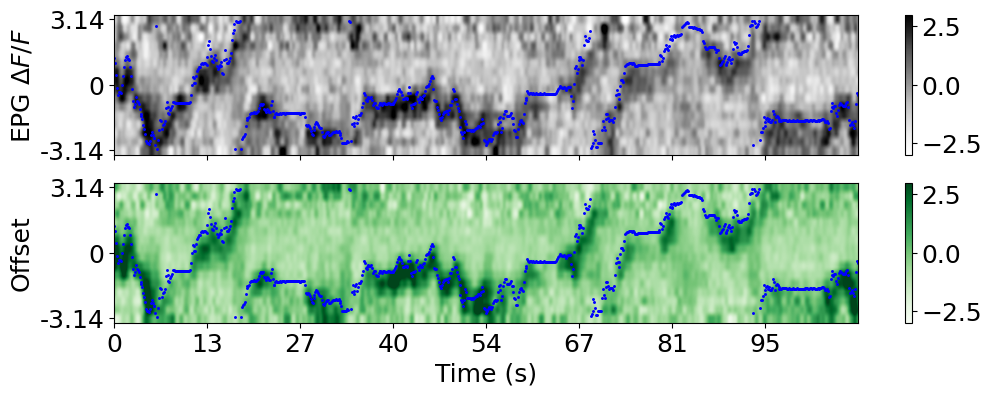

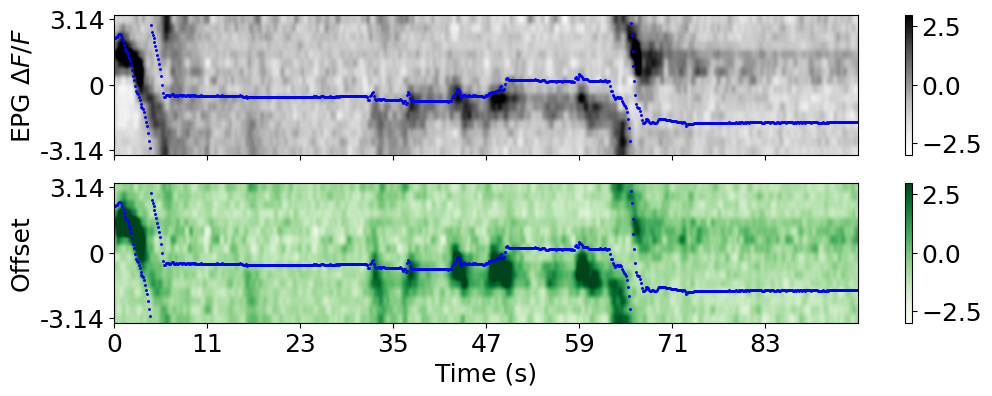

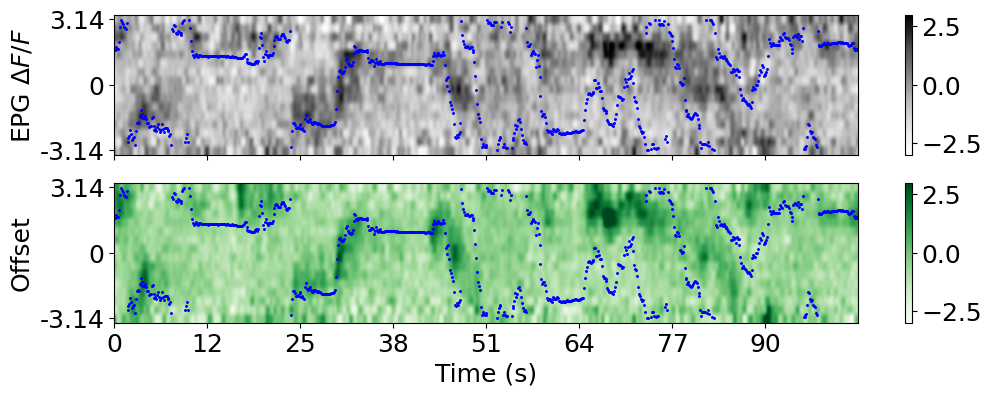

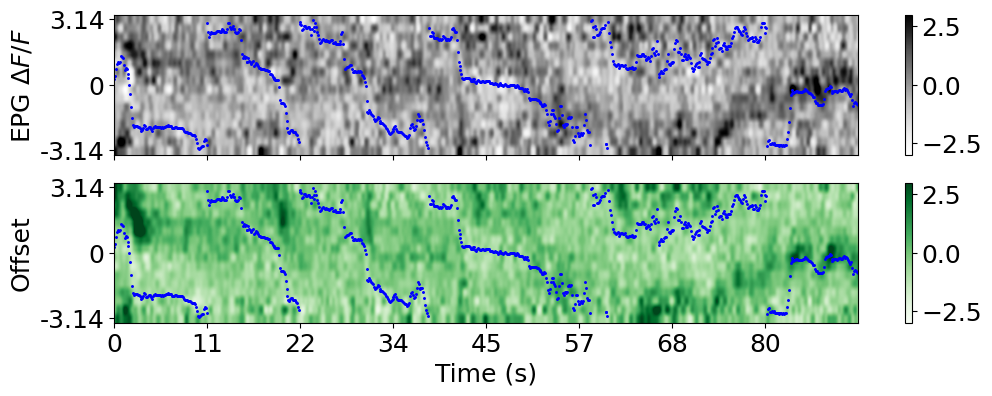

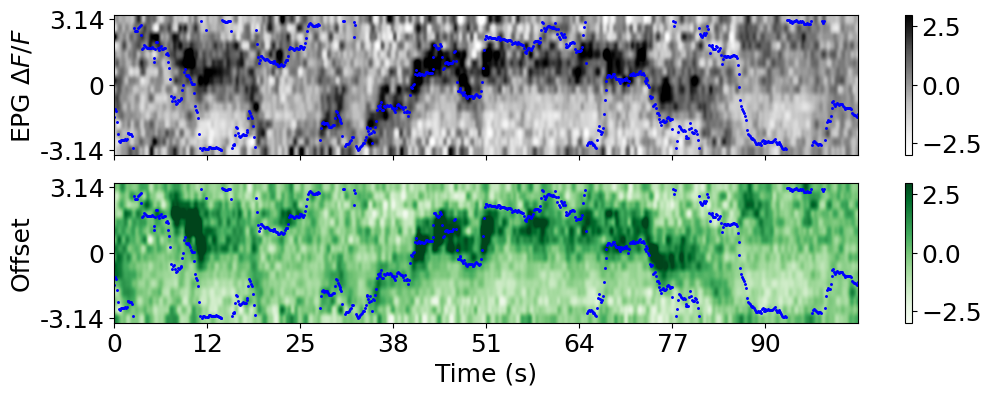

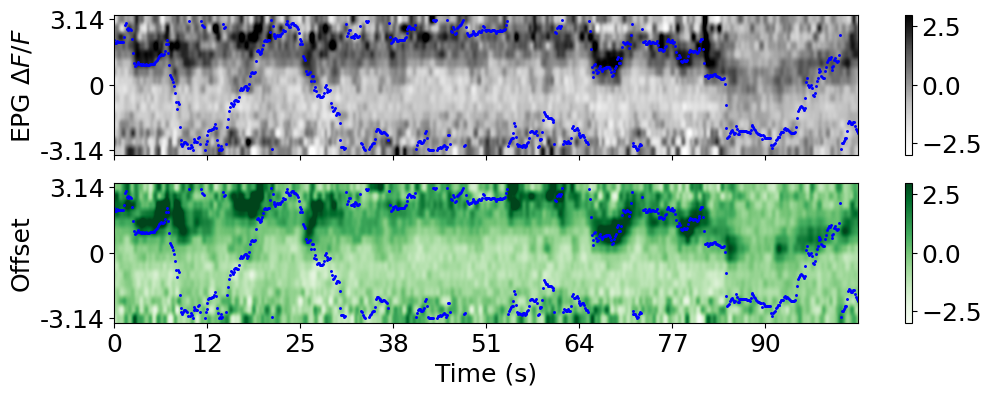

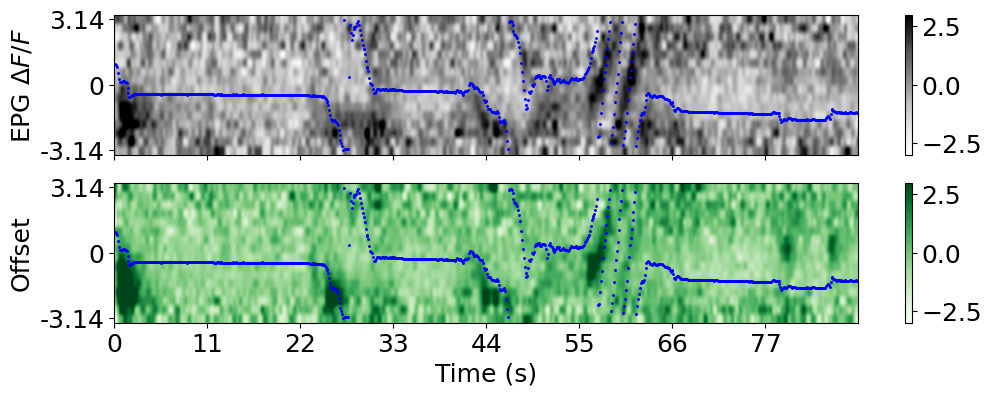

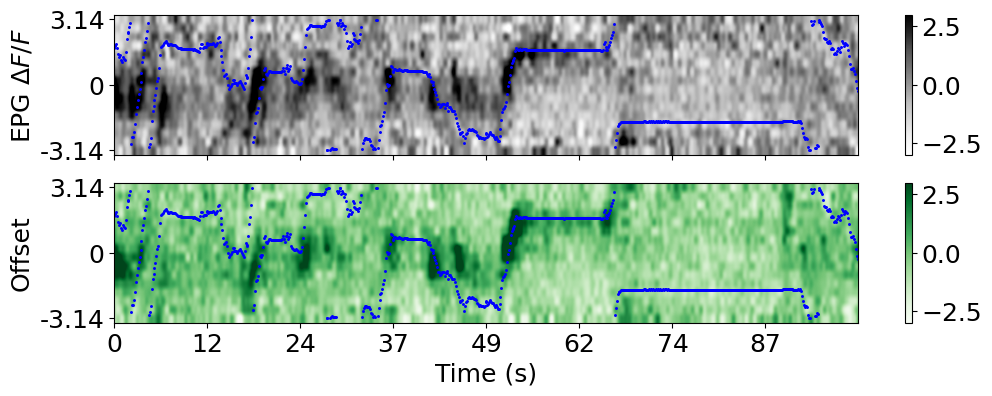

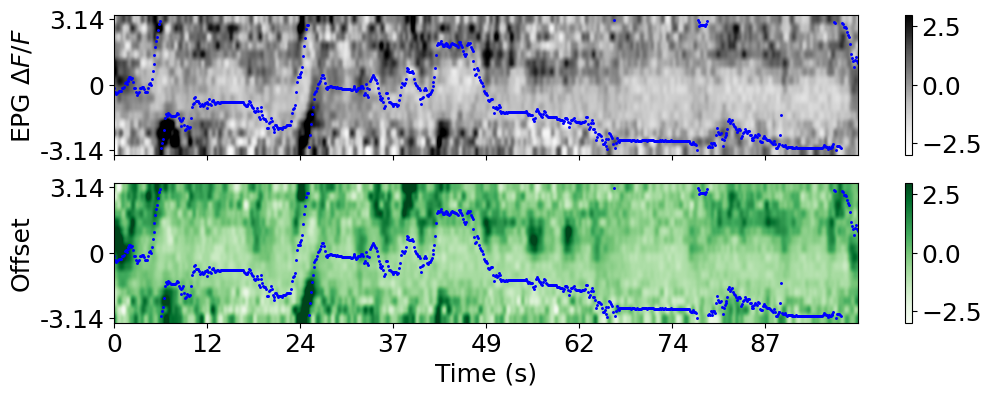

In [18]:
# plot each session
window = slice(0,800)
for s in sess_info:
    print(s)
    sess = load_session(s)
    
    
    for i, scan in enumerate(sess.session_list):
        print(i)

        dff = sess.timeseries['dff'][i][:,:,window]
        heading = sess.timeseries['heading'][i][window]
        offset = sess.timeseries['offset'][i]
        frame_times = sess.timeseries['voltage_recording'][i]['Time(ms)'][window]
        dac2 = sess.timeseries['voltage_recording'][i][' Arena DAC2']

        fig, ax = plt.subplots(2,1,figsize=[12,4], sharex=True)
        h_green = ax[0].imshow(dff[1,:,:],aspect='auto',cmap='Greys',vmin=-3,vmax=3)
        plt.colorbar(h_green, ax=ax[0])
        ax[0].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
        ax[0].set_ylabel(r"EPG $\Delta F/F$")

        x = np.arange(heading.shape[0])
        ax[0].scatter(x,15*(heading+np.pi)/2/np.pi,color='blue',marker='.',s=5)


        h_red = ax[1].imshow(dff[0,:,:],aspect='auto',cmap='Greens',vmin=-3,vmax=3)
        plt.colorbar(h_red, ax = ax[1])
        ax[1].scatter(x,15*(heading+np.pi)/2/np.pi,color='blue',marker='.',s=5)

        ax[1].set_yticks([0,7.5,15], ['3.14', '0', '-3.14'])
        ax[1].set_ylabel(r"EL $\Delta F/F$")



        # ax[2].scatter(x,offset[1,:],s=2, color='Black')
        # ax[2].scatter(x,offset[0,:],s=2, color='Purple')
        # fig.colorbar(h_red, ax=ax[2])
        # ax[2].set_ylim([-3.14,3.14])
        # ax[2].set_yticks([-3.14,0,3.14], ['-3.14', '0', '3.14'])
        
# # # ax[1].plot(x,0*offset[window], marker='_')


        ax[1].set_ylabel('Offset')
        ax[1].set_xlabel('Time (s)')


        ax[1].set_xticks(x[0::100], labels=[str(int((frame_times[i]-frame_times[0])/1000)) for i in range(0,x[-1]+1,100)])
        
        
        # ax[3].plot(x, dac2)
        
        dirname = f"/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/EL_imaging/{s['date']}/{s['name']}"
        os.makedirs(dirname, exist_ok=True)
        fname = f"{dirname}/dff.pdf"
        fig.savefig(fname,format='pdf')
        
        
        # fig,ax = plt.subplots()
#         bin_edges = np.linspace(-np.pi, np.pi, num=15)
#         bin_centers = (bin_edges[:-1]+bin_edges[1:])/2.
#         epg_counts, _ = np.histogram(offset[1,:],bins=bin_edges)
#         ax.fill_between(bin_centers, epg_counts/epg_counts.sum(), alpha=.3, color='black', label='EPG')
#         el_counts, _ = np.histogram(offset[0,:],bins=bin_edges)
#         ax.fill_between(bin_centers, el_counts/el_counts.sum(), alpha=.3, color='purple', label='EL')
#         ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
#         ax.set_xlabel('offset (radians)')
        
#         ax.set_yticks([])
#         ax.spines['top'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.legend(loc='upper left')
        
#         # fname = f"/media/mplitt/SSD_storage/2P_scratch/{s['date']}/{s['name']}/{scan}/offset.pdf"
#         fname = f"{dirname}/offset.pdf"
#         fig.savefig(fname,format='pdf')
        # ax.plot

{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['baseline_open_loop-003']}
(5042,)
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
(10444,)
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
(10559,)
{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['baseline_open_loop-000']}
(5042,)
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-002', 'open_loop_baseline-003', 'closed_loop_to_dark-006', 'closed_loop_to_dark-007']}
(17142,)
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-001', 'open_loop_baseline-003', 'closed_loop_to_dark-004']}
(13116,)
(6, 1000)


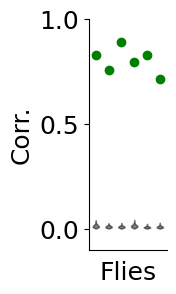

In [15]:
corr = []
shuff_corr = []
rng = np.random.default_rng()
for i,s in enumerate(sess_info):
    print(s)
    sess = load_session(s)
    
    
    mask = sess.timeseries_concat['voltage_recording'][' Arena DAC2'].to_numpy()>-1
    
    pva_angle = sess.timeseries_concat['pva_angle']
    pva_amp = sess.timeseries_concat['pva_amp']

    re, cp = st2p.utilities.pol2cart(np.ones(pva_angle.shape), pva_angle)
    pv = re + 1j*cp

    corr.append(np.absolute(1/pv.shape[1]*np.correlate(pv[0,:],pv[1,:], mode='valid'))[0])
    
    _shuff_corr = []
    pv1 = np.copy(pv[1,:])
    print(pv1.shape)
    for i in range(1000):
        rng.shuffle(pv1)
        _shuff_corr.append(np.absolute(1/pv.shape[1]*np.correlate(pv[0,:], pv1)[0]))
        
    # print(np.absolute(corr))
    shuff_corr.append(_shuff_corr)
shuff_corr = np.array(shuff_corr)
print(shuff_corr.shape)

fig,ax = plt.subplots(figsize=[1,3])
ax.scatter(np.arange(len(sess_info)), corr, color = 'green')
parts = ax.violinplot(shuff_corr.T, positions= np.arange(len(sess_info)),showmeans=False, showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('black')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim([-.1,1])
ax.set_xticks([])
ax.set_xlabel('Flies')
ax.set_ylabel('Corr.')


figdir = f"/media/mplitt/SSD_storage/fig_scratch/cosyne_2024/figures/EL_imaging/"
os.makedirs(figdir,exist_ok=True)
fig.savefig(figdir+"EL_EPG_corr.pdf",format='pdf')





{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['baseline_open_loop-003']}
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
{'date': '16_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-000', 'open_loop_baseline-001']}
{'date': '15_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['baseline_open_loop-000']}
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly1', 'session_list': ['open_loop_baseline-002', 'open_loop_baseline-003', 'closed_loop_to_dark-006', 'closed_loop_to_dark-007']}
{'date': '17_03_2023', 'name': 'EPG_GCaMP_EL_jRGECO_fly2', 'session_list': ['open_loop_baseline-001', 'open_loop_baseline-003', 'closed_loop_to_dark-004']}


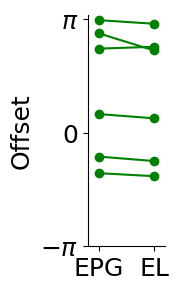

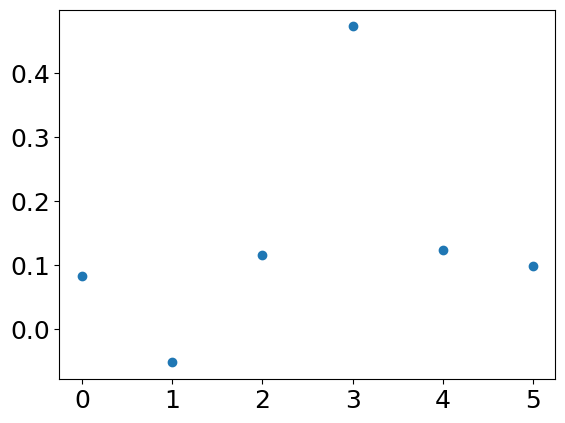

In [12]:
avg_offsets = np.zeros([2,len(sess_info)])
for i,s in enumerate(sess_info):
    print(s)
    sess = load_session(s)
    
    
    mask = sess.timeseries_concat['voltage_recording'][' Arena DAC2'].to_numpy()>-1
    
    offset = sess.timeseries_concat['offset']
    re, cp = st2p.utilities.pol2cart(np.ones(offset.shape), offset)
    offset_c = re + 1j*cp
    
    avg_offsets[:,i] = np.angle(offset_c.mean(axis=-1))
    
fig,ax = plt.subplots(figsize=[1,3])
for i,_ in enumerate(sess_info):
    ax.plot([0,1],avg_offsets[:,i], color='green',marker='o')

ax.set_ylim([-np.pi+.1, np.pi+.1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([-np.pi, 0, np.pi], labels=[r'$-\pi$', r'0', r'$\pi$'])
ax.set_xticks([0,1], labels=['EPG', 'EL'])
ax.set_xlim([-.2,1.2])
ax.set_ylabel('Offset')
fig.savefig(figdir+"EL_EPG_offset.pdf",format='pdf')
  
    
fig,ax = plt.subplots()
ax.scatter(np.arange(len(sess_info)), avg_offsets[0,:]-avg_offsets[1,:])
    

0.8898144510198385
1


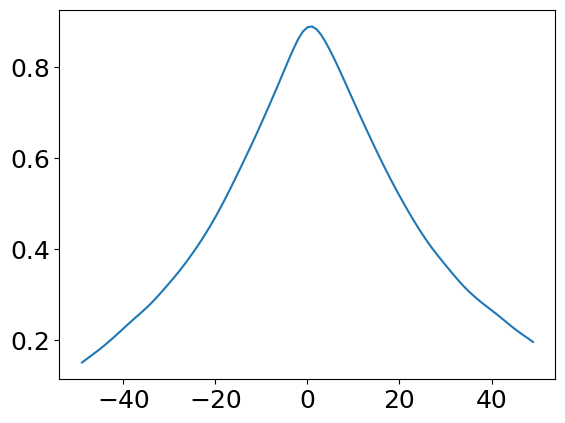

In [50]:
for s in sess_info:
    print(s)
    sess = load_session(s)
    
    


# plot cross correlation of EPG and EL timeseries
sess = load_session(sess_info[2])

pva_angle = sess.timeseries_concat['pva_angle']
pva_amp = sess.timeseries_concat['pva_amp']

re, cp = st2p.utilities.pol2cart(np.ones(pva_angle.shape), pva_angle)
pv = re + 1j*cp

xcorr = 1/pv.shape[1]*np.correlate(pv[0,:],pv[1,:], mode='full')

xcorr = 1/pva_angle.shape[1]*np.correlate(np.exp(1j*pva_angle[0,:]),np.exp(1j*pva_angle[1,:]), mode='full')


fig,ax = plt.subplots()
x = np.arange(-pva_angle.shape[1]+1,pva_angle.shape[1])
mask = (x<50)*(x>-50)
ax.plot(x[mask], xcorr[mask].real)
print(np.amax(np.absolute(xcorr)))
print(x[np.argmax(np.abs(xcorr))])

# r,p = sp.stats.pearsonr(pv[0,:],pv[1,:])
# example session 

# across fly average

In [51]:
heading = sess.timeseries_concat['voltage_recording'][' Heading'].to_numpy()

0.10285438309370187 3.114424550199806e-26
0.1520867571409797 1.1451329137915964e-55
0.15327591291478582 0.10321940250628014
3.6365977298174106


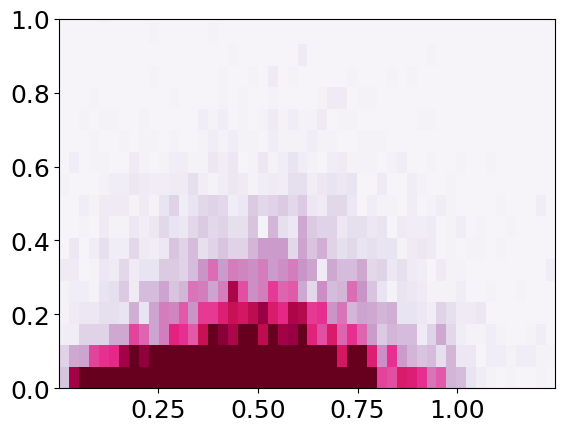

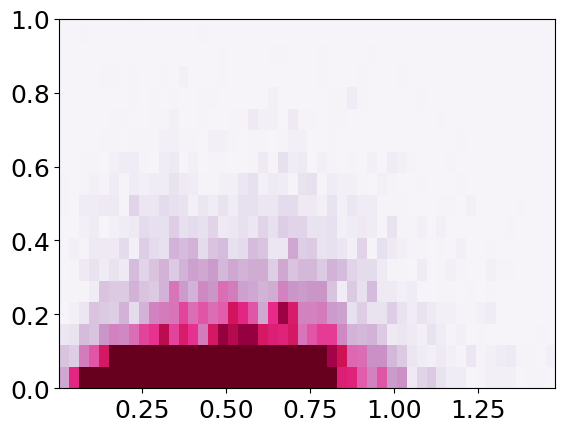

In [59]:
re,cpx = st2p.utilities.pol2cart(np.ones(heading.shape), heading)
heading_cpx = re + 1j*cpx

# fig,ax = plt.subplots()
# ax.plot(np.angle(heading_cpx[:600]))
# ax.plot(np.angle(np.exp(1j*np.diff(np.angle(heading_cpx[:600])))))

rho,dphi = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),np.diff(heading,prepend=0)))
# ax.plot(dphi[:600])

fig,ax = plt.subplots()
ax.hist2d(pva_amp[1,:], np.abs(dphi),bins=50,density=True,vmax=3,cmap='PuRd')
ax.set_ylim([0,1])
# ax.scatter(np.abs(dphi), pva_amp[1,:])
r_epg,p = sp.stats.pearsonr(np.abs(dphi),pva_amp[1,:])
# sp.stats.linregress(
print(r_epg,p)


fig,ax = plt.subplots()
# ax.scatter(np.abs(dphi), pva_amp[0,:])
ax.hist2d(pva_amp[0,:],np.abs(dphi),bins=50,density=True,vmax=3,cmap='PuRd')
r_el,p = sp.stats.pearsonr(np.abs(dphi),pva_amp[0,:])
ax.set_ylim([0,1])
print(r_el,p)

z_el = np.arctanh(r_el)
z_epg = np.arctanh(r_epg)
print(z_el, z_epg)
print((z_el-z_epg)/ np.sqrt((2/(dphi.shape[0]-3))))


In [53]:
X = np.column_stack((pva_amp[1,:], np.abs(dphi)))
X = sm.add_constant(X)

In [54]:
model = sm.OLS(pva_amp[0,:], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     7459.
Date:                Thu, 13 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:47:54   Log-Likelihood:                 4683.0
No. Observations:               10559   AIC:                            -9360.
Df Residuals:                   10556   BIC:                            -9338.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0505      0.004     12.996      0.0

In [60]:
X = np.column_stack((pva_amp[1,:],))
X = sm.add_constant(X)
model = sm.OLS(pva_amp[0,:], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.459e+04
Date:                Thu, 13 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:51:32   Log-Likelihood:                 4613.4
No. Observations:               10559   AIC:                            -9223.
Df Residuals:                   10557   BIC:                            -9208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0595      0.004     15.504      0.0

In [61]:
X = np.column_stack((np.abs(dphi),))
X = sm.add_constant(X)
model = sm.OLS(pva_amp[0,:], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     250.0
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           1.15e-55
Time:                        19:52:31   Log-Likelihood:                 155.59
No. Observations:               10559   AIC:                            -307.2
Df Residuals:                   10557   BIC:                            -292.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4575      0.003    158.728      0.0

In [ ]:
# bump in the darkness

